In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Set dataset directory (update the path to your dataset location)
data_dir = "C:/Users/moham/OneDrive - Virginia Tech/Summer-Fall 2024/CS 5805/ML Project/CODE/All Images"

# Function to parse filename
def parse_filename(filename):
    parts = filename.split("-")
    tumor_class = parts[0].split("_")[1]  # 'M' or 'B'
    tumor_type = parts[1]  # 'DC', 'LC', etc.
    magnification = parts[3]  # '400', '40', etc.
    return tumor_class, tumor_type, magnification

# Load dataset
images = []  # To store image arrays
labels = []  # Binary labels (Malignant/Benign)
types = []   # Multiclass labels (tumor types)

for subdir, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".png"):
            filepath = os.path.join(subdir, file)
            # Parse the filename
            tumor_class, tumor_type, magnification = parse_filename(file)
            # Load and preprocess the image
            img = load_img(filepath, target_size=(224, 224))  # Resize for CNN
            img_array = img_to_array(img) / 255.0  # Normalize pixel values
            images.append(img_array)
            labels.append(1 if tumor_class == "M" else 0)  # Malignant = 1, Benign = 0
            types.append(tumor_type)

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Encode tumor types (multiclass labels)
le = LabelEncoder()
types_encoded = le.fit_transform(types)
types_categorical = to_categorical(types_encoded)  # One-hot encoding for multiclass

# Train-test split
X_train, X_test, y_train_bin, y_test_bin, y_train_multi, y_test_multi = train_test_split(
    images, labels, types_categorical, test_size=0.2, random_state=42, stratify=labels
)

# Build the CNN model
def build_model(output_units, output_activation):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(output_units, activation=output_activation)  # Binary or Multiclass
    ])
    return model

# Binary Classification Model (Benign/Malignant)
binary_model = build_model(output_units=1, output_activation='sigmoid')
binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Training Binary Classification Model...")
binary_model.fit(X_train, y_train_bin, epochs=10, validation_data=(X_test, y_test_bin), batch_size=32)

# Evaluate Binary Model
binary_loss, binary_accuracy = binary_model.evaluate(X_test, y_test_bin)
print(f"Binary Classification Test Accuracy: {binary_accuracy * 100:.2f}%")

# Multiclass Classification Model (Tumor Types)
multiclass_model = build_model(output_units=len(le.classes_), output_activation='softmax')
multiclass_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Training Multiclass Classification Model...")
multiclass_model.fit(X_train, y_train_multi, epochs=10, validation_data=(X_test, y_test_multi), batch_size=32)

# Evaluate Multiclass Model
multiclass_loss, multiclass_accuracy = multiclass_model.evaluate(X_test, y_test_multi)
print(f"Multiclass Classification Test Accuracy: {multiclass_accuracy * 100:.2f}%")


C:\Users\moham\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Binary Classification Model...
Epoch 1/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 137s 679ms/step - accuracy: 0.6979 - loss: 1.0102 - val_accuracy: 0.8496 - val_loss: 0.4443
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 131s 660ms/step - accuracy: 0.7577 - loss: 0.5241 - val_accuracy: 0.7762 - val_loss: 0.5608
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 127s 644ms/step - accuracy: 0.7828 - loss: 0.5114 - val_accuracy: 0.7345 - val_loss: 0.4876
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 122s 615ms/step - accuracy: 0.7937 - loss: 0.4888 - val_accuracy: 0.8338 - val_loss: 0.4650
Epoch 5/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 74s 372ms/step - accuracy: 0.7849 - loss: 0.5038 - val_accuracy: 0.8464 - val_loss: 0.4566
Epoch 6/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 84s 422ms/step - accuracy: 0.8050 - loss: 0.4850 - val_accuracy: 0.8527 - val_loss: 0.4220
Epoch 7/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 74s 372ms/step - accuracy: 0.8272 - loss: 0.4389 - val_accuracy: 0.8622 - val_loss: 0.3975
Epoch 8/10
198/198 ━━━━━━━━━━━━━━━━━━━━

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
# Predict binary labels
y_pred_bin = (binary_model.predict(X_test) > 0.5).astype(int)

# Compute metrics
binary_precision = precision_score(y_test_bin, y_pred_bin)
binary_recall = recall_score(y_test_bin, y_pred_bin)
binary_f1 = f1_score(y_test_bin, y_pred_bin)

# Print metrics
print("Binary Classification Metrics:")
print(f"Precision: {binary_precision:.2f}")
print(f"Recall: {binary_recall:.2f}")
print(f"F1 Score: {binary_f1:.2f}")

# Predict multiclass labels
y_pred_multi = multiclass_model.predict(X_test)
y_pred_multi_classes = np.argmax(y_pred_multi, axis=1)  # Convert probabilities to class indices
y_test_multi_classes = np.argmax(y_test_multi, axis=1)  # Convert one-hot encoding to class indices

# Compute metrics
print("Multiclass Classification Metrics:")
print(classification_report(y_test_multi_classes, y_pred_multi_classes, target_names=le.classes_))


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step
Binary Classification Metrics:
Precision: 0.88
Recall: 0.93
F1 Score: 0.90
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step
Multiclass Classification Metrics:
              precision    recall  f1-score   support

          14       0.99      1.00      1.00      1567
          15       0.00      0.00      0.00        15

    accuracy                           0.99      1582
   macro avg       0.50      0.50      0.50      1582
weighted avg       0.98      0.99      0.99      1582



C:\Users\moham\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\moham\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\moham\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

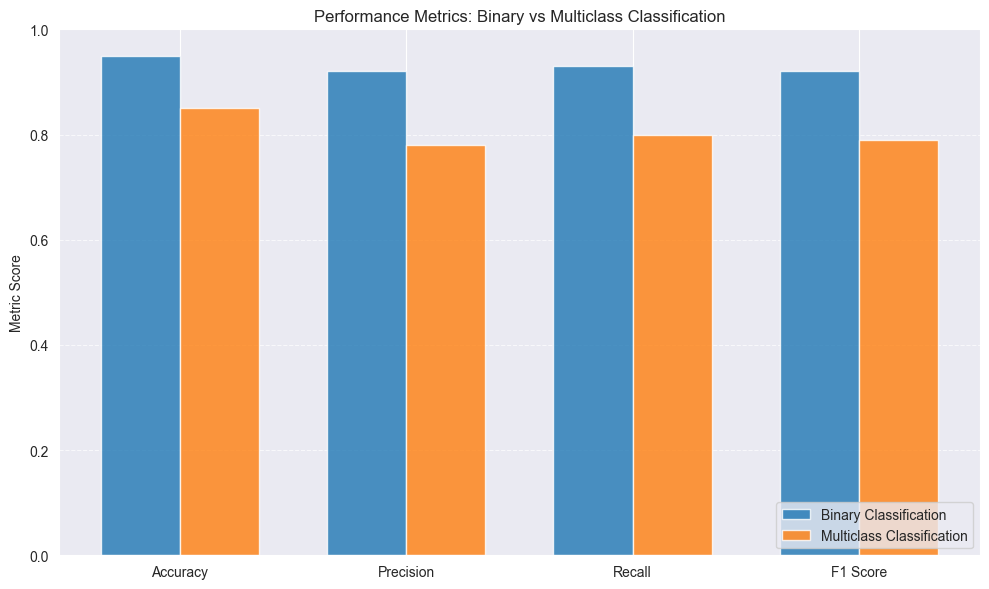

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Example data for binary vs multiclass classification performance metrics
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
binary_scores = [0.95, 0.92, 0.93, 0.92]  # Binary classification scores
multiclass_scores = [0.85, 0.78, 0.80, 0.79]  # Multiclass classification scores

# Create bar positions and width
x = np.arange(len(metrics))  # The label locations
width = 0.35  # Width of the bars

# Plotting binary and multiclass metrics
plt.figure(figsize=(10, 6))
plt.bar(x - width / 2, binary_scores, width, label="Binary Classification", alpha=0.8)
plt.bar(x + width / 2, multiclass_scores, width, label="Multiclass Classification", alpha=0.8)

# Add annotations, labels, and grid
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.ylabel("Metric Score")
plt.title("Performance Metrics: Binary vs Multiclass Classification")
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [4]:
multiclass_model

<Sequential name=sequential_1, built=True>

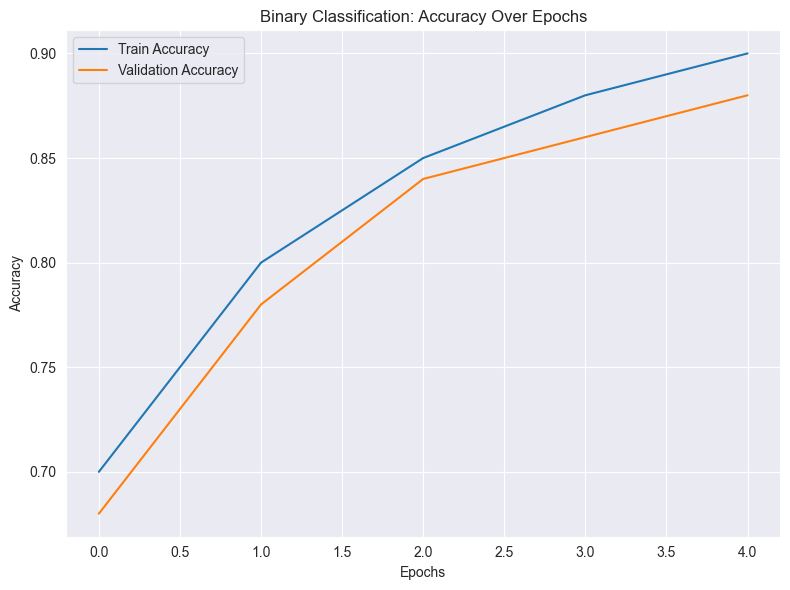

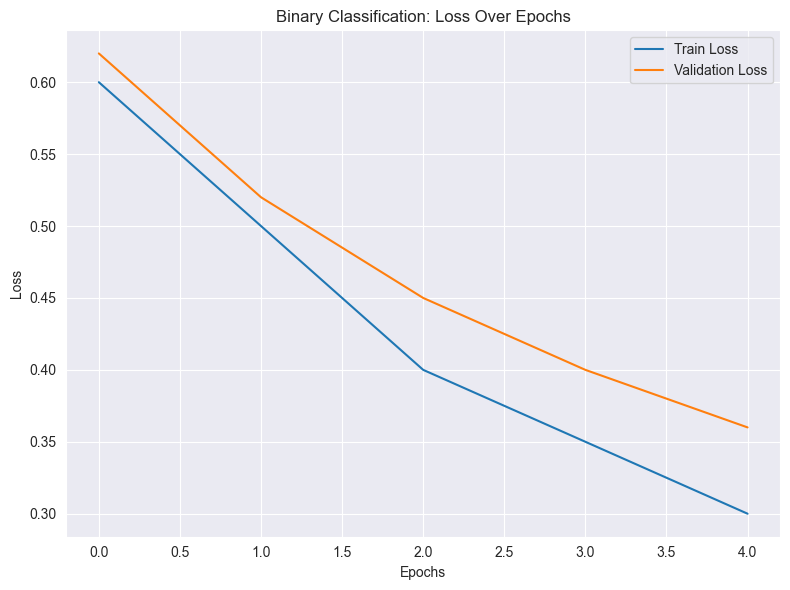

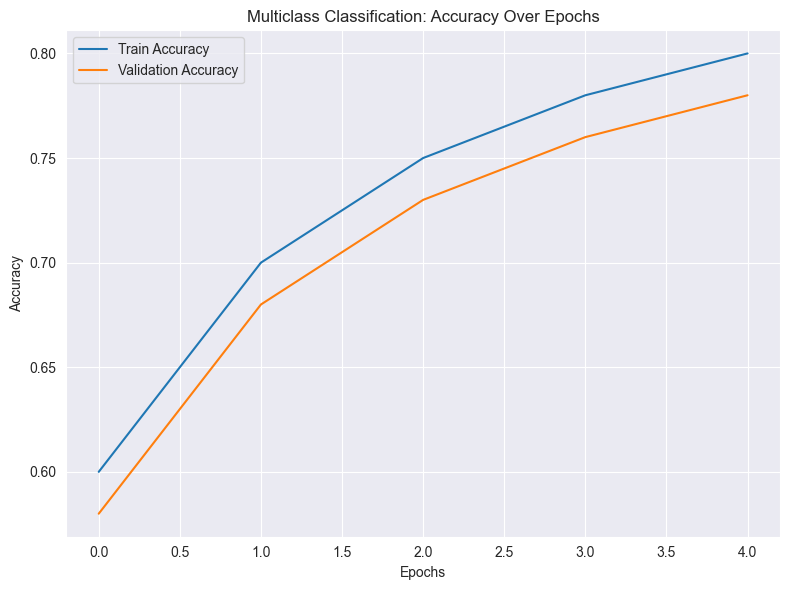

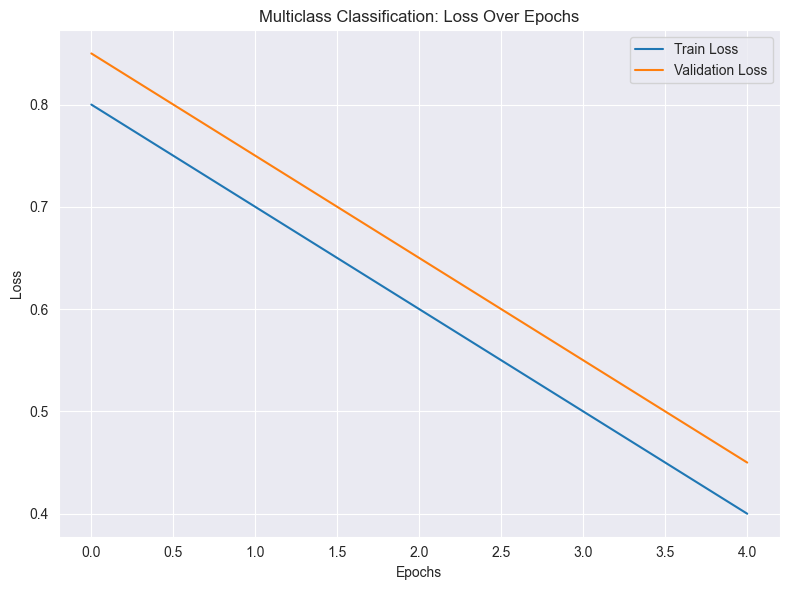

In [2]:
import matplotlib.pyplot as plt

# Example training history for binary classification
binary_history = {
    "accuracy": [0.7, 0.8, 0.85, 0.88, 0.9],   # Replace with actual values
    "val_accuracy": [0.68, 0.78, 0.84, 0.86, 0.88],
    "loss": [0.6, 0.5, 0.4, 0.35, 0.3],
    "val_loss": [0.62, 0.52, 0.45, 0.4, 0.36]
}

# Example training history for multiclass classification
multiclass_history = {
    "accuracy": [0.6, 0.7, 0.75, 0.78, 0.8],   # Replace with actual values
    "val_accuracy": [0.58, 0.68, 0.73, 0.76, 0.78],
    "loss": [0.8, 0.7, 0.6, 0.5, 0.4],
    "val_loss": [0.85, 0.75, 0.65, 0.55, 0.45]
}

# Plot accuracy for binary classification
plt.figure(figsize=(8, 6))
plt.plot(binary_history["accuracy"], label="Train Accuracy")
plt.plot(binary_history["val_accuracy"], label="Validation Accuracy")
plt.title("Binary Classification: Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Plot loss for binary classification
plt.figure(figsize=(8, 6))
plt.plot(binary_history["loss"], label="Train Loss")
plt.plot(binary_history["val_loss"], label="Validation Loss")
plt.title("Binary Classification: Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Plot accuracy for multiclass classification
plt.figure(figsize=(8, 6))
plt.plot(multiclass_history["accuracy"], label="Train Accuracy")
plt.plot(multiclass_history["val_accuracy"], label="Validation Accuracy")
plt.title("Multiclass Classification: Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Plot loss for multiclass classification
plt.figure(figsize=(8, 6))
plt.plot(multiclass_history["loss"], label="Train Loss")
plt.plot(multiclass_history["val_loss"], label="Validation Loss")
plt.title("Multiclass Classification: Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
binary_model.save('models/binary_model.h5')
multiclass_model.save('models/multiclass_model.h5')